### Домашнее задание к лекции «Поиск выбросов и генерация новых признаков»

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
1. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
1. Построить случайный лес, вывести важность признаков
1. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
1. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
1. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
1. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [3]:
df = pd.read_csv('train_kaggle.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

У признаков Alley, PoolQC, MiscFeature слишком много пропущенных значений (заполнено значениями < 100 строк). Удалим эти столбцы

In [5]:
df = df.drop(['Alley', 'PoolQC', 'MiscFeature'], axis=1)

In [8]:
df.isna().sum()[df.isna().sum()!=0]

LotFrontage      259
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
Fence           1179
dtype: int64

Мы планируем использовать алгоритм random forest. Этот алгоритм должен хорошо справляться с наличием пропусков в данных, если мы разметим для него эти пропуски. Проставим в пропущенные значения у числовых признаков метку (-999), у категориальных - метку ('Nan')

In [6]:
df[df.dtypes[df.dtypes == object].index]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,Min1,TA,Attchd,Unf,TA,TA,Y,MnPrv,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Typ,Gd,Attchd,RFn,TA,TA,Y,GdPrv,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,WD,Normal


Прежде, чем воспользоваться алгоритмом random forest, необходимо что-то сделать с категориальными признаками: либо исключить их из модели либо преобразовать к числовому типу данных 

In [13]:
cat_feat = list(df[df.dtypes[df.dtypes == object].index])
cat_nunique = df[cat_feat].nunique()
print(cat_nunique)

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
Fence             4
SaleType          9
SaleCondition     6
dtype: int64


Уникальных значений не очень много для каждого категориального признака. Можно перевести их one hot encoding-ом в числовые. Датасет получится более разреженным, но мы сохраним информацию из всех столбцов

In [14]:
dummy_cols = pd.get_dummies(df[cat_feat], columns=cat_feat)
num_feat = [f for f in df if f not in (cat_feat + ['Id', 'SalePrice'])]
X = pd.concat([df[num_feat].fillna(-999), dummy_cols.fillna('NaN')], axis=1) #заполним отсутствующие значения

In [15]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 279 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(3), int64(33), uint8(243)
memory usage: 757.2 KB


In [17]:
X.isna().sum()[X.isna().sum()!=0]

Series([], dtype: int64)

In [18]:
Y = df['SalePrice']

In [21]:
from sklearn.metrics import  r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

Разобьем данные на train и test. 

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=146)

#### Random forest

Применим к этим данным алгоритм random forest, поэксперементируем с гиперпараметрами 

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
parameters = {
    'n_estimators':[10, 20, 30, 40, 50, 70, 100],
    'max_depth': list(range(2, 10)),
    'min_samples_leaf': [3, 5, 10, 15, 20, 30],
    'min_samples_split': list(range(2, 10))
}

In [29]:
tree_grid = GridSearchCV(RandomForestRegressor(), parameters, cv = 7, n_jobs=-1)
tree_grid.fit(x_train, y_train)

GridSearchCV(cv=7, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [3, 5, 10, 15, 20, 30],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [10, 20, 30, 40, 50, 70, 100]})

In [30]:
print(tree_grid.best_params_)

{'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 50}


In [31]:
best_tree = tree_grid.best_estimator_

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
y_pred_rf_best = best_tree.predict(x_test)
print('Random forest best regressor metrics: ')
print(f'Score: {best_tree.score(x_test, y_test)}')
print(f'R2: {r2_score(y_pred_rf_best, y_test)}')

Random forest best regressor metrics: 
Score: 0.8075056832322683
R2: 0.7876830880099795


In [47]:
cross_val_rf_mean = np.mean(cross_val_score(best_tree, x_test, y_test, cv = 10, scoring = 'r2' ))
cross_val_rf_mean

0.744107490289073

Случайный лес с подобранными гиперпараметрами дает неплохой результат Score: 0.807, R2: 0.787. Однако кросс-валидация демонстрирует более сдержанные результаты (R2: 0.744), что скорее всего является более объективной оценкой

Выведем график, отражающий важность фичей. Так как после всех преобразований категориальных признаков в числовые общее количество признаков 288, ограничимся 10ю наиболее важными, чтобы не создавать громоздкую визуализацию

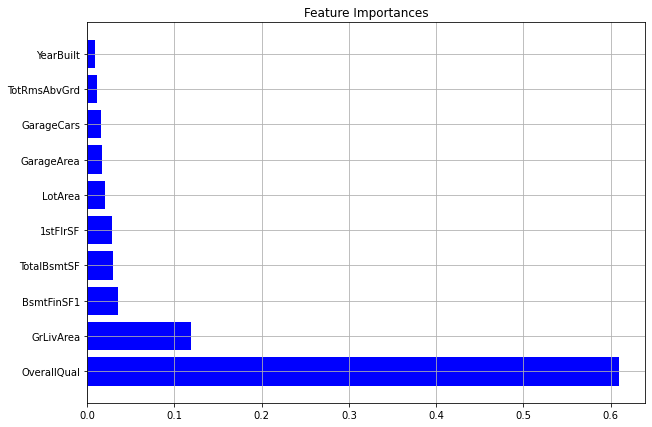

In [41]:
features = X.columns
importances = best_tree.feature_importances_
indices = np.argsort(importances)
pairs = list(zip(importances[indices], [features[i] for i in indices]))
top10 = sorted(pairs, key=lambda x:x[0], reverse=True)[:10]

plt.figure(figsize=(10,7))
plt.title('Feature Importances')
plt.barh(range(len(top10)), [x[0] for x in top10], color='b', align='center')
plt.yticks(range(len(top10)), [x[1] for x in top10])
plt.grid()
plt.show()

К наиболее значимым модель отнесла признаки OverallQual (оценка материалов и отделки дома) и GrLivArea (надземная жилая площадь в кв. футах)

#### Стекинг

In [42]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

Рекомендуется помещать в стек непохожие друг на друга модели, возьмем ридж-регрессию, дерево-регрессор и SVR, в качестве мета-регрессора используем линейную регрессию

In [43]:
stregr = StackingRegressor(
    [
        ('rdg', Ridge()),
        ('dr', DecisionTreeRegressor()),
        ('svr', SVR(kernel='linear'))
    ],
LinearRegression())

In [44]:
stregr.fit(x_train, y_train)
y_pred_stack = stregr.predict(x_test)
print('Stacking metrics: ')
print(f'Score: {stregr.score(x_test, y_test)}')
print(f'R2: {r2_score(y_pred_stack, y_test)}')

Stacking metrics: 
Score: 0.856356895018729
R2: 0.8406552041020546


Хорошие показатели, даже лучше чем у случайного леса после подбора гиперпараметров

Так же применим кросс-валидацию и здесь.

In [48]:
cross_val_stack_mean = np.mean(cross_val_score(stregr, x_test, y_test, cv = 10, scoring = 'r2' ))
cross_val_stack_mean

0.6362444975419053

In [49]:
score_list = []
r2_list = []

score_list.append(best_tree.score(x_test, y_test))
r2_list.append(r2_score(y_pred_rf_best, y_test))

for est in stregr.named_estimators_:
    y_pr = stregr.named_estimators_[est].predict(x_test)
    score_list.append(stregr.named_estimators_[est].score(x_test, y_test))
    r2_list.append(r2_score(y_pr, y_test))
    
score_list.append(stregr.score(x_test, y_test)) 
r2_list.append(r2_score(y_pred_stack, y_test)) 

In [56]:
est_list = ['random forest', 'ridge', 'decision tree', 'svr', 'stack']
df_score = pd.DataFrame(data=np.array([est_list, score_list, r2_list]).T, columns=['estimator', 'score', 'R2'])
df_score[['score', 'R2']] = df_score[['score', 'R2']].apply(pd.to_numeric)
df_score

,estimator,score,R2
0,random forest,0.807506,0.787683
1,ridge,0.824501,0.831184
2,decision tree,0.710529,0.738800
3,svr,0.743407,0.660177
4,stack,0.856357,0.840655


In [57]:
df_score.loc[0, 'cross_val_r2'] = cross_val_rf_mean
df_score.loc[4, 'cross_val_r2'] = cross_val_stack_mean
df_score

,estimator,score,R2,cross_val_r2
0,random forest,0.807506,0.787683,0.744107
1,ridge,0.824501,0.831184,NaN
2,decision tree,0.710529,0.738800,NaN
3,svr,0.743407,0.660177,NaN
4,stack,0.856357,0.840655,0.636244


Так выглядят метрики для стека и для каждой модели, входящей в его состав. Очевидно, что ансамблирование привело к лучшим результатам, чем каждая из этих моделей могла показать самостоятельно. Однако интересно, что кросс-валидация сильно уронила средний показатель R2 для стека